# eBay 

The dataset, `ebay_ho2.parquet`, contains rows, each corresponding to a sold item on eBay under the *Best Offer* platform. 

The data comes from https://www.nber.org/research/data/best-offer-sequential-bargaining, from the paper “Sequential Bargaining in the Field: Evidence from Millions of Online Interactions” by Backus, Blake, Larsen & Tadelis (2020) in the Quarterly Journal of Economics. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize

In [2]:
dat = pd.read_parquet('ebay_ho2.parquet')

In [3]:
dat.shape

(7903479, 22)

Variable labels in human readable form

In [4]:
var_labels = {'anon_item_id': 'Anonymized listing ID',
              'anon_leaf_categ_id': 'Anonymized leaf category ID, a finer categorization than meta categor',
              'fdbk_pstv_start':'sellers percent feedback score at the time of the listin',
              'start_price_usd': 'Buy-It-Now price', 'photo_count': 'Number of photos in listing', 
              'to_lst_cnt': 'Number of listings created by the seller dating back to 2008',
              'bo_lst_cnt': 'Number of BO-listings created by the seller dating back to 2008',
              'item_cndtn_id': 'Indicator for the new/used status of the item',
              'view_item_count': 'Number of times the item page was viewed',
              'wtchr_count': 'Number of users who selected the "add to watch list" option for this listing',              
              'anon_product_id': 'Anonymized product ID, only available for items that can be linked to specific cataloged products', 
              'count1': 'Number of listings used in creating ref_price1 for this observation',
              'ref_price1': 'Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data',   
              'item_price': 'Final price (Buy-It-Now price if the item sold through Buy-It-Now option, or the final negotiated price if the item sold through Best Offer. ',
              'bo_ck_yn': 'Indicator for whether item sold through best offer.',
              'decline_price': 'Price chosen by seller, if the seller chooses to report one, below which any offer will be automatically rejected', 
              'accept_price': 'Price chosen by seller, if the seller chooses to report one, above which any offer will be automatically accepted', 
              'bin_rev': 'Indicator for whether the Buy-It-Now price was ever modified by the seller during the time the item was listed', 
              'lstg_gen_type_id': 'Indicator for whether the item is a re-listing (i.e. an item that failed to sell before and was then re-listed by the seller)', 
              'store': 'Indicator for whether the listing is part of an eBay store',
              'slr_us': 'Indicator for whether seller is located in US or not', 
              'buyer_us': 'Indicator for whether buyer is located in US or not', 
              'metacat': 'Product category (broad)', 
              'item_condition': 'Indicator for the new/used status of the item (categorical).', 
              'price2ref': 'Price relative to avg. among identical products (ref_price1)', 
              'price2start': 'Price relative to starting price (start_price_usd)'
             }

In [5]:
for v in dat.columns: 
    print(f'{v:<20}: {var_labels[v]}')

anon_product_id     : Anonymized product ID, only available for items that can be linked to specific cataloged products
anon_leaf_categ_id  : Anonymized leaf category ID, a finer categorization than meta categor
fdbk_pstv_start     : sellers percent feedback score at the time of the listin
start_price_usd     : Buy-It-Now price
photo_count         : Number of photos in listing
to_lst_cnt          : Number of listings created by the seller dating back to 2008
bo_lst_cnt          : Number of BO-listings created by the seller dating back to 2008
count1              : Number of listings used in creating ref_price1 for this observation
ref_price1          : Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data
view_item_count     : Number of times the item page was viewed
wtchr_count         : Number of users who selected the "add to watch list" option for this listing
item_price          : Final price (Buy-It-Now price 

# Create variables

In [6]:
dat['price2ref']   = dat['item_price'] / dat['ref_price1']
dat['price2start'] = dat['item_price'] / dat['start_price_usd']

In [7]:
price_vars = ['item_price', 'price2ref', 'price2start']

In [8]:
price_labs = {'price2ref':'Price rel. to avg. for product', 'price2start':'Price rel. to starting price', 
              'item_price':'Price (USD)'}

# A few descriptives, just for curiosity

## Number of sales per category

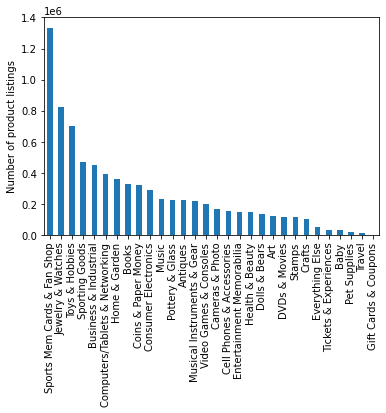

In [9]:
ax=dat.metacat.value_counts().plot(kind='bar'); 
ax.set_ylabel('Number of product listings'); 

## Price distributions

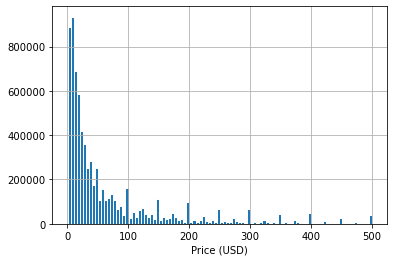

In [10]:
I = dat.item_price <= 500 # just to remove a few outliers 
ax = dat.loc[I].item_price.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['item_price']); 

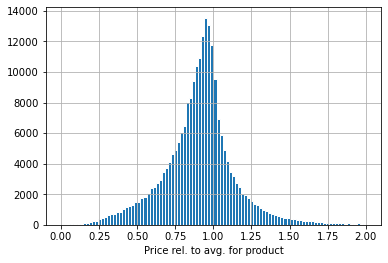

In [11]:
I = (dat.price2ref <= 2.0) & (dat.count1 >= 10) # if count1<10, then the reference price gets very noisy
ax = dat.loc[I].price2ref.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['price2ref']); 

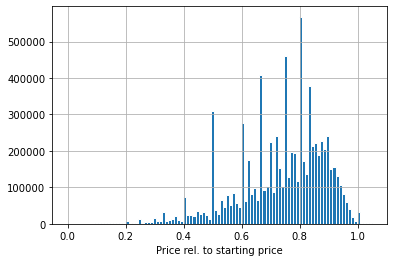

In [12]:
I = (dat.price2start <= 1.05) 
ax = dat.loc[I].price2start.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['price2start']); 

# Compare prices for two specific categories

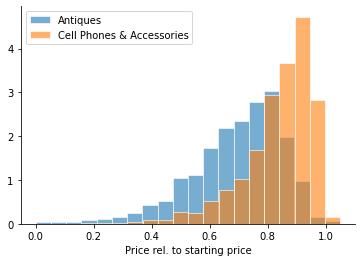

In [13]:
cats = ['Antiques',  'Cell Phones & Accessories']

fig,ax = plt.subplots(); 
for cat in cats: 
    I = (dat['price2start'] < 1.05) & (dat.metacat == cat)
    ax.hist(dat.loc[I, 'price2start'], bins=20, label=cat, alpha=0.6, density=True, edgecolor='white')

ax.legend(loc='best'); ax.set_xlabel(price_labs['price2start']); sns.despine();     

# Part A: Uniform valuations

This section focuses on the variable `price2start`, which is neatly distributed between 0 and 1, motivating us to focus on the uniform distribution. 

In [14]:
d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()
d

,price2start,view_item_count
metacat,,
Antiques,0.697898,45.201430
Art,0.678380,33.178491
Baby,0.759839,38.750195
Books,0.697726,19.118065
Business & Industrial,0.720395,36.085501
Cameras & Photo,0.795037,52.978987
Cell Phones & Accessories,0.842814,64.304693
Coins & Paper Money,0.794811,31.213884
Computers/Tablets & Networking,0.796257,45.466562


... continue on your own from here... write a function that takes `d.view_item_count` as an input and returns a predicted price. The data price that this should be compared to is `d.price2start`. 

# Part B: Non-uniformly Distributed Valuations

Now, we instead focus on the price variable, `price2ref`. 

In [15]:
price_var = 'price2ref'

## Subset the dataset

In [16]:
I = (dat.metacat == 'Cell Phones & Accessories') & (dat.price2ref < 2.0) & (dat.count1 >= 10)
d = dat[I].copy() # to avoid having a pointer 

Showing the overall distribution of that price

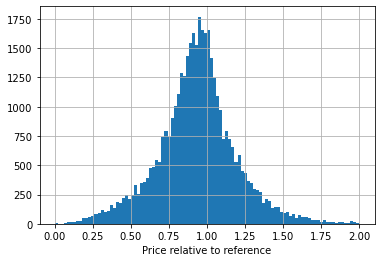

In [17]:
d[price_var].hist(bins=100); 
plt.xlabel('Price relative to reference'); 

## Question B.1

In [18]:
n = 10
R = 100000

# chi square distributed valuations
v = np.random.chisquare(1, size=(n,R))
# next, find the winning price for each column, r=1,...,R
# save an R-vector with the winning payments
# ... 
win_chi2 = None # fill in 

# log normal draws
w = np.exp(np.random.normal(-0.5, 0.5, size=(n,R)))
# ... and do the same here 
# ... 
win_lognorm = None # fill in 

In [ ]:
# if you called the variables "win_chi2" and "win_lognorm", 
# then this code creates a graph with the histograms together 
fig,ax = plt.subplots(); 
ax.hist(win_chi2,       alpha=0.5, density=True, bins=100, label='chi2');      # winning bids with chi squared distributed valuations
ax.hist(win_lognorm,    alpha=0.5, density=True, bins=100, label='lognormal'); # ... with log normals 
ax.hist(d['price2ref'], alpha=0.5, density=True, bins=100, label='Observed');  # the data we want to compare to 
ax.legend(loc='best'); sns.despine(); 

## Question B.2

Find the $\mu$ that best fits the data. Two approaches: 
1. Just evaluate histograms for different values of $\mu$ and search "with your eye" *(minimum acceptable solution)* 
2. Minimize the "distance" between the simulated and real data. See the attached notebook, `ecdf.ipynb` for help. 

In [ ]:
# 1. set up the grid on which we will be evaluating the ECDF functions
plow = 0.0
phigh = 2.0
xx = np.linspace(plow, phigh, 50)

# 2. construct the empirical CDF function handles
# ECDF returns a *function* which you can then evaluate at a vector of points 
ecdf_dat = ECDF(d['price2ref']) # the CDF function for the data 
ecdf_sim = ECDF(win_lognorm) # the variable from question B.1

# 3. show a plot together 
# we evaluate the two cdf functions on the same grid
plt.plot(xx, ecdf_dat(xx), '-o', xx, ecdf_sim(xx), '-x'); 
plt.legend(['Data', 'Simulation']); 

# 4. compute the L2 distance between the two CDF functions
# (see ecdf.ipynb for help with this)
L2 = np.mean((ecdf_dat(xx) - ecdf_sim(xx))**2)
print(f'L2 criterion for these values = {L2:6.3f}')